## Training on the WaDi Data Set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.graphics.tsaplots import plot_acf
import math
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
# import torch
# from torch.utils.data import Dataset, DataLoader, TensorDataset
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import random
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from tabulate import tabulate

2026-01-15 10:20:55.514693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [78]:
Train_df = pd.read_csv("/home/brandon/data/WADI_14days_new.csv")
Train_df = Train_df.drop(columns = ['Row'])
Train_df['Date'] = pd.to_datetime(Train_df['Date'], format='mixed')
Train_df['Attack_Label'] = np.ones(Train_df.shape[0], dtype='float32')
Train_df

,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,Attack_Label
0,2017-09-25,00:00.0,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,...,1,1,1,1,1,1,67.9651,1,0.68,1.0
1,2017-09-25,00:01.0,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,...,1,1,1,1,1,1,67.9651,1,0.68,1.0
2,2017-09-25,00:02.0,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,...,1,1,1,1,1,1,67.9651,1,0.68,1.0
3,2017-09-25,00:03.0,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,...,1,1,1,1,1,1,67.1948,1,0.68,1.0
4,2017-09-25,00:04.0,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,...,1,1,1,1,1,1,67.1948,1,0.68,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784566,2017-10-07,16:06.0,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,...,1,1,1,1,1,1,60.6305,1,0.25,1.0
784567,2017-10-07,16:07.0,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,...,1,1,1,1,1,1,60.6305,1,0.25,1.0
784568,2017-10-07,16:08.0,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,...,1,1,1,1,1,1,60.6305,1,0.25,1.0
784569,2017-10-07,16:09.0,175.896,0.613476,11.8913,479.224,0.331622,0.001173,0,0,...,1,1,1,1,1,1,60.4477,1,0.25,1.0


In [73]:
attack_df = pd.read_csv("/home/brandon/data/WADI_attackdataLABLE.csv", header = 1)
attack_df['Date'] = attack_df['Date ']
attack_df = attack_df[attack_df['Row '] <= 172801.0]
attack_df['Attack_Label'] = attack_df['Attack LABLE (1:No Attack, -1:Attack)']
attack_df = attack_df.drop(columns = ['Row ', 'Date ', 'Attack LABLE (1:No Attack, -1:Attack)'])
attack_df

,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,...,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,Date,Attack_Label
0,00:00.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
1,00:01.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
2,00:02.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
3,00:03.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
4,00:04.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172796,59:56.0,172.959,0.547483,11.9184,466.034,0.318217,0.001222,0.0,0.0,55.5587,...,1.0,1.0,1.0,1.0,1.0,59.3546,1.0,0.00,10/11/17,1
172797,59:57.0,172.959,0.547483,11.9184,466.034,0.318217,0.001222,0.0,0.0,55.5587,...,1.0,1.0,1.0,1.0,1.0,59.3546,1.0,0.00,10/11/17,1
172798,59:58.0,172.915,0.583479,11.9211,466.051,0.318317,0.001260,0.0,0.0,55.7260,...,1.0,1.0,1.0,1.0,1.0,58.8102,1.0,0.00,10/11/17,1
172799,59:59.0,172.915,0.583479,11.9211,466.051,0.318317,0.001260,0.0,0.0,55.7260,...,1.0,1.0,1.0,1.0,1.0,58.8102,1.0,0.00,10/11/17,1


In [75]:
Val_df = attack_df.loc[attack_df['Date'] == '10/9/17'].copy()

# # 3. Create the Test DataFrame (Test_df) as the remainder
# # Test_df = attack_df.loc[attack_df['Date'] != '10/9/17'].copy()

# #Free up memory after splitting val and test sets
del attack_df

In [79]:
# Drop columns that are always NaN
# Identify columns that are always NaN in the training set
always_nan_cols = Train_df.columns[Train_df.isnull().all()].tolist()

print(f"\nNumber of columns that are always NaN in training data: {len(always_nan_cols)}")
print("Always-NaN columns:")
print(always_nan_cols)

Train_df = Train_df.drop(columns=always_nan_cols)
Val_df = Val_df.drop(columns=always_nan_cols)
# Test_df  = Test_df.drop(columns=always_nan_cols)

print("\nAfter dropping always-NaN columns:")
print(f"Train shape: {Train_df.shape}")
print(f"Val shape:   {Val_df.shape}")
# print(f"Test shape:  {Test_df.shape}")


Number of columns that are always NaN in training data: 4
Always-NaN columns:
['2_LS_001_AL', '2_LS_002_AL', '2_P_001_STATUS', '2_P_002_STATUS']

After dropping always-NaN columns:
Train shape: (784571, 126)
Val shape:   (21600, 126)


In [33]:
# target_col = ['1_AIT_002_PV', '1_AIT_004_PV', '2B_AIT_004_PV','3_AIT_004_PV']
# fig, axes = plt.subplots(nrows=len(target_col), ncols=1, figsize=(12, 10), sharex=True)

# for i, col in enumerate(target_col):
#     axes[i].plot(subset.index, subset[col], label=col, color='tab:blue')
#     axes[i].set_ylabel('Value')
#     axes[i].legend(loc='upper right')
#     axes[i].grid(True, alpha=0.3)

# plt.suptitle('Sensor Values Over Time (Gaps indicate NaNs)')
# plt.xlabel('Time Index')
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

In [80]:
# Use appropriate methods to handle missing values
# Use liner interpolation for missing values that spread out across the data
Train_df['1_AIT_002_PV'] = Train_df['1_AIT_002_PV'].interpolate(method='linear')
Train_df['1_AIT_004_PV'] = Train_df['1_AIT_004_PV'].interpolate(method='linear')
Train_df['2B_AIT_004_PV'] = Train_df['2B_AIT_004_PV'].interpolate(method='linear')
# Use forward fill for missing values that occur in blocks
Train_df['3_AIT_004_PV'] = Train_df['3_AIT_004_PV'].ffill()

In [84]:
# 4a. Find features using Train_df (as before)
features_original = [c for c in Train_df.columns if c not in ['Date', 'Time']]
constant_features = [col for col in features_original if Train_df[col].nunique() == 1]
features_final = [col for col in features_original if col not in constant_features]
print(f"Number of constant features removed: {len(constant_features)}")

scaler = MinMaxScaler()

# Transform the data using the NumPy arrays X_train, X_val, X_test
Train_scaled = scaler.fit_transform(Train_df[features_final])
Val_scaled = scaler.transform(Val_df[features_final])
# Test_scaled = scaler.transform(Test_df[features_final])

y_train = Train_df['Attack_Label'].values.astype('float32')
y_val = Val_df['Attack_Label'].values.astype('float32')
# y_test = Test_df['Attack_Label'].values.astype('float32')

Number of constant features removed: 31


In [85]:
train_ex = Train_df[features_final]

val_ex = Val_df[features_final]

val_no_attk = Val_df[Val_df['Attack_Label'] == 1.0][features_final]



counter = 0
problems = []

for feature in features_final:

    train_mean = round(train_ex[feature].mean(), 3)

    val_mean = round(val_no_attk[feature].mean(), 3)

    if abs(train_mean - val_mean) > 6:

        print(f"Feature: {feature}, Train Mean: {train_mean}, Val Mean: {val_mean}")

        counter += 1
        problems.append(feature)

print(f"Total features with mean difference > 6: {counter}")

Feature: 1_AIT_004_PV, Train Mean: 493.761, Val Mean: 462.821
Feature: 2_DPIT_001_PV, Train Mean: 2518.565, Val Mean: 2537.342
Feature: 2_FIC_201_CO, Train Mean: 64.519, Val Mean: 54.517
Feature: 2_FIC_301_CO, Train Mean: 67.393, Val Mean: 51.632
Feature: 2_FIC_501_CO, Train Mean: 61.578, Val Mean: 45.084
Feature: 2_FIC_601_CO, Train Mean: 63.571, Val Mean: 52.2
Feature: 2A_AIT_004_PV, Train Mean: 486.743, Val Mean: 477.827
Feature: 2B_AIT_004_PV, Train Mean: 491.05, Val Mean: 478.134
Feature: 3_AIT_002_PV, Train Mean: 7056.66, Val Mean: 8279.1
Feature: 3_AIT_004_PV, Train Mean: 644.167, Val Mean: 569.0
Total features with mean difference > 6: 10


In [69]:
def make_window_dataset(
    data,
    window_size,
    stride=1,
    batch_size=64
):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(
        size=window_size,
        shift=stride,
        drop_remainder=True
    )

    ds = ds.flat_map(lambda w: w.batch(window_size))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # Autoencoder objective: X → X
    ds = ds.map(lambda x: (x, x))

    return ds

In [71]:
WINDOW_SIZE = 100
STRIDE = 1
BATCH_SIZE = 64
NUM_FEATURES = len(features_final)

train_ds = make_window_dataset(
    Train_scaled,
    window_size=WINDOW_SIZE,
    stride=10,
    batch_size=BATCH_SIZE
)

val_ds = make_window_dataset(
    Val_scaled,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    batch_size=BATCH_SIZE
)

y_val_ds = make_window_dataset(
    y_val,
    window_size=WINDOW_SIZE, 
    stride=STRIDE, 
    batch_size=BATCH_SIZE
)
# Extract label windows (resulting shape: [N_windows, 100, 1])
y_val_windows = np.concatenate([y for y, _ in y_val_ds], axis=0)

is_attack_window = np.any(y_val_windows < 0, axis=-1)

GRU_y_val_np = np.where(is_attack_window, -1, 1).flatten()


2026-01-15 11:25:39.517788: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 560.30MiB (rounded to 587517696)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2026-01-15 11:25:39.517821: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2026-01-15 11:25:39.517833: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 59, Chunks in use: 56. 14.8KiB allocated for chunks. 14.0KiB in use in bin. 270B client-requested in use in bin.
2026-01-15 11:25:39.517839: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 6, Chunks in use: 3. 3.0KiB allocated for chunks. 1.5KiB in use in bin. 1.1KiB client-requested in use in bin.
2026-01-

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

ework/bfc_allocator.cc:1105] InUse at 7fab4bc4c200 of size 1536 next 27
2026-01-15 11:25:39.518077: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at 7fab4bc4c800 of size 256 next 26
2026-01-15 11:25:39.518081: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at 7fab4bc4c900 of size 256 next 28
2026-01-15 11:25:39.518084: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at 7fab4bc4ca00 of size 47360 next 29
2026-01-15 11:25:39.518088: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at 7fab4bc58300 of size 49152 next 30
2026-01-15 11:25:39.518092: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at 7fab4bc64300 of size 512 next 31
2026-01-15 11:25:39.518096: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at 7fab4bc64500 of size 256 next 32
2026-01-15 11:25:39.518099: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at 7fab4bc64600 of size 256 next 25


### GRU

In [28]:
#GRU
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'
tf.config.experimental.enable_op_determinism()

GRU_model = GRU_model = keras.Sequential([
    keras.Input(shape=(WINDOW_SIZE, NUM_FEATURES)),

    #Encoder
    layers.GRU(units=64, return_sequences=False),
    #layers.Dropout(0.2),
    layers.RepeatVector(WINDOW_SIZE), #Repeat vector to match the input sequence length

    #Decoder
    layers.GRU(units=64, return_sequences=True),
    #layers.Dropout(0.2),
    layers.TimeDistributed(layers.Dense(NUM_FEATURES)) #Get predictions for each time step
])

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
GRU_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

GRU_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        30,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 10, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 93)         │         6,045 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,533 (240.36 KB)

 Trainable params: 61,533 (240.36 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the GRU
GRU_history = GRU_model.fit(
    train_ds,
    validation_data = (val_ds),
    epochs = 30,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)
    ]
)

Epoch 1/30


2026-01-15 10:41:15.116921: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


  12252/Unknown 64s 5ms/step - loss: 0.0123 - mae: 0.0614

2026-01-15 10:42:18.060985: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-15 10:42:18.061013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624
/home/brandon/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.0102 - mae: 0.0550 - val_loss: 0.0192 - val_mae: 0.0910
Epoch 2/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:04 5ms/step - loss: 0.0212 - mae: 0.0854

2026-01-15 10:42:19.010764: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12250/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - mae: 0.0449

2026-01-15 10:43:22.003316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624
2026-01-15 10:43:22.003346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11121338298469405299
2026-01-15 10:43:22.003356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16220455639305174648


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0070 - mae: 0.0442 - val_loss: 0.0119 - val_mae: 0.0712
Epoch 3/30
   32/12259 ━━━━━━━━━━━━━━━━━━━━ 1:02 5ms/step - loss: 0.0151 - mae: 0.0653

2026-01-15 10:43:22.809731: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-15 10:43:22.809765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12251/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - mae: 0.0394

2026-01-15 10:44:25.537739: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624
2026-01-15 10:44:25.537769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11121338298469405299


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0057 - mae: 0.0392 - val_loss: 0.0090 - val_mae: 0.0601
Epoch 4/30
   32/12259 ━━━━━━━━━━━━━━━━━━━━ 1:02 5ms/step - loss: 0.0142 - mae: 0.0593

2026-01-15 10:44:26.323184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0045 - mae: 0.0348 - val_loss: 0.0100 - val_mae: 0.0628
Epoch 5/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:03 5ms/step - loss: 0.0136 - mae: 0.0562

2026-01-15 10:45:30.044984: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-15 10:45:30.045010: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 389523360869647923
2026-01-15 10:45:30.045037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0036 - mae: 0.0314 - val_loss: 0.0076 - val_mae: 0.0554
Epoch 6/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:04 5ms/step - loss: 0.0123 - mae: 0.0520

2026-01-15 10:46:34.267558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12256/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - mae: 0.0282

2026-01-15 10:47:37.196128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0030 - mae: 0.0285 - val_loss: 0.0067 - val_mae: 0.0511
Epoch 7/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:04 5ms/step - loss: 0.0118 - mae: 0.0503

2026-01-15 10:47:37.981436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12251/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mae: 0.0261

2026-01-15 10:48:41.249423: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0026 - mae: 0.0264 - val_loss: 0.0061 - val_mae: 0.0490
Epoch 8/30
   30/12259 ━━━━━━━━━━━━━━━━━━━━ 1:06 5ms/step - loss: 0.0112 - mae: 0.0502

2026-01-15 10:48:42.037015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12256/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - mae: 0.0246

2026-01-15 10:49:45.416869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624
2026-01-15 10:49:45.416896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11121338298469405299
2026-01-15 10:49:45.416903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16220455639305174648


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0023 - mae: 0.0249 - val_loss: 0.0051 - val_mae: 0.0448
Epoch 9/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:04 5ms/step - loss: 0.0101 - mae: 0.0459

2026-01-15 10:49:46.197819: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-15 10:49:46.197852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853
2026-01-15 10:49:46.197858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16923593032366300202
2026-01-15 10:49:46.197864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 389523360869647923


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0021 - mae: 0.0238 - val_loss: 0.0048 - val_mae: 0.0444
Epoch 10/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:05 5ms/step - loss: 0.0090 - mae: 0.0470

2026-01-15 10:50:50.469235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853
2026-01-15 10:50:50.469266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 389523360869647923


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0019 - mae: 0.0228 - val_loss: 0.0047 - val_mae: 0.0436
Epoch 11/30
   32/12259 ━━━━━━━━━━━━━━━━━━━━ 1:02 5ms/step - loss: 0.0077 - mae: 0.0445

2026-01-15 10:51:54.702768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12257/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mae: 0.0219

2026-01-15 10:52:58.635629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624
2026-01-15 10:52:58.635659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11121338298469405299
2026-01-15 10:52:58.635668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16220455639305174648


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.0018 - mae: 0.0221 - val_loss: 0.0043 - val_mae: 0.0415
Epoch 12/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:03 5ms/step - loss: 0.0069 - mae: 0.0441

2026-01-15 10:52:59.423697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853
2026-01-15 10:52:59.423727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 389523360869647923


12251/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mae: 0.0212

2026-01-15 10:54:02.595310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624
2026-01-15 10:54:02.595338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11121338298469405299


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0017 - mae: 0.0215 - val_loss: 0.0042 - val_mae: 0.0420
Epoch 13/30
12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0016 - mae: 0.0208 - val_loss: 0.0036 - val_mae: 0.0392
Epoch 14/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:05 5ms/step - loss: 0.0053 - mae: 0.0390

2026-01-15 10:55:07.574319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853
2026-01-15 10:55:07.574350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16923593032366300202
2026-01-15 10:55:07.574360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 389523360869647923


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0015 - mae: 0.0202 - val_loss: 0.0032 - val_mae: 0.0370
Epoch 15/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:05 5ms/step - loss: 0.0048 - mae: 0.0372

2026-01-15 10:56:11.979352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12252/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mae: 0.0194

2026-01-15 10:57:15.666887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624
2026-01-15 10:57:15.666913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11121338298469405299
2026-01-15 10:57:15.666919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16220455639305174648


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0015 - mae: 0.0198 - val_loss: 0.0033 - val_mae: 0.0372
Epoch 16/30
   32/12259 ━━━━━━━━━━━━━━━━━━━━ 1:03 5ms/step - loss: 0.0044 - mae: 0.0370

2026-01-15 10:57:16.466395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0014 - mae: 0.0193 - val_loss: 0.0031 - val_mae: 0.0363
Epoch 17/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:05 5ms/step - loss: 0.0042 - mae: 0.0364

2026-01-15 10:58:20.423280: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-15 10:58:20.423320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853
2026-01-15 10:58:20.423330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16923593032366300202
2026-01-15 10:58:20.423340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 389523360869647923


12256/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0185

2026-01-15 10:59:23.691860: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624
2026-01-15 10:59:23.691892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11121338298469405299
2026-01-15 10:59:23.691900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16220455639305174648


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0013 - mae: 0.0188 - val_loss: 0.0030 - val_mae: 0.0363
Epoch 18/30
   29/12259 ━━━━━━━━━━━━━━━━━━━━ 1:07 6ms/step - loss: 0.0039 - mae: 0.0363

2026-01-15 10:59:24.470659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0013 - mae: 0.0183 - val_loss: 0.0029 - val_mae: 0.0362
Epoch 19/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:05 5ms/step - loss: 0.0036 - mae: 0.0348

2026-01-15 11:00:28.829558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853
2026-01-15 11:00:28.829588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16923593032366300202
2026-01-15 11:00:28.829596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 389523360869647923


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0012 - mae: 0.0180 - val_loss: 0.0026 - val_mae: 0.0333
Epoch 20/30
   31/12259 ━━━━━━━━━━━━━━━━━━━━ 1:01 5ms/step - loss: 0.0033 - mae: 0.0336

2026-01-15 11:01:33.169426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


12258/12259 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0172

2026-01-15 11:02:36.329061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10384510964986306624
2026-01-15 11:02:36.329093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11121338298469405299
2026-01-15 11:02:36.329101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16220455639305174648


12259/12259 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - loss: 0.0011 - mae: 0.0175 - val_loss: 0.0025 - val_mae: 0.0331
Epoch 21/30
12259/12259 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.0011 - mae: 0.0170 - val_loss: 0.0024 - val_mae: 0.0322
Epoch 22/30
   30/12259 ━━━━━━━━━━━━━━━━━━━━ 1:08 6ms/step - loss: 0.0030 - mae: 0.0323

2026-01-15 11:03:41.652452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8688203420296747853


 3640/12259 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.0010 - mae: 0.0165

KeyboardInterrupt: 

In [81]:
# --- 1. Get Predictions and Ground Truth from the Dataset ---
print("Generating predictions...")
# .predict() works directly on the dataset
GRU_X_val_pred = GRU_model.predict(val_ds) 

# Extract the "Ground Truth" input windows from the dataset
# We iterate over the dataset to concatenate all batches into one numpy array
X_val_np = np.concatenate([x for x, _ in val_ds], axis=0)

GRU_reconstruction_error = np.mean(np.square(GRU_X_val_pred - X_val_np), axis=(1, 2))

# --- 4. Evaluation ---
GRU_BEST_THRESHOLD = 0.05

GRU_y_pred_labels = np.where(GRU_reconstruction_error > GRU_BEST_THRESHOLD, -1, 1)

GRU_prec, GRU_rec, GRU_f1, _ = precision_recall_fscore_support(
    GRU_y_val_np, GRU_y_pred_labels, average='binary',pos_label=-1, zero_division=0
)

# Calculate metrics
GRU_mean_error = np.mean(GRU_reconstruction_error)
GRU_std_error = np.std(GRU_reconstruction_error)
GRU_training_error = GRU_history.history['loss'][-1]
GRU_validation_error = GRU_history.history['val_loss'][-1]

print("-" * 30)
print(f"GRU Metrics: Mean Error = {GRU_mean_error:.4f}, Std Dev = {GRU_std_error:.4f}")
print(f"Training Loss = {GRU_training_error:.4f}, Validation Loss = {GRU_validation_error:.4f}")
print("-" * 30)
print(f"Precision: {GRU_prec:.3f}")
print(f"Recall:    {GRU_rec:.3f}")
print(f"F1 Score:  {GRU_f1:.3f}")
print("-" * 30)

Generating predictions...
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
------------------------------
GRU Metrics: Mean Error = 0.0036, Std Dev = 0.0027
Training Loss = 0.0039, Validation Loss = 0.0036
------------------------------
Precision: 0.000
Recall:    0.000
F1 Score:  0.000
------------------------------


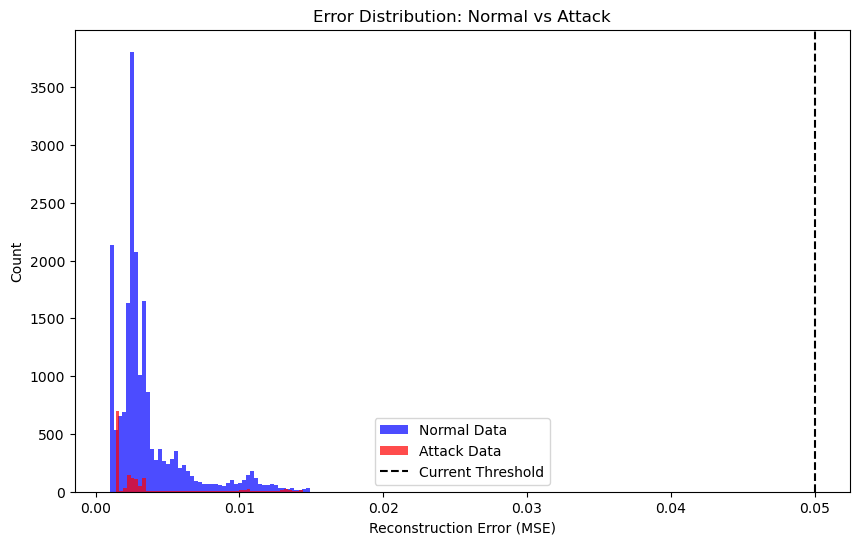

Normal Error | Mean: 0.0036 | Max: 0.0149
Attack Error | Mean: 0.0036 | Min: 0.0014
Seperation Gap: -0.0135


In [82]:
normal_errors = GRU_reconstruction_error[GRU_y_val_np == 1]
attack_errors = GRU_reconstruction_error[GRU_y_val_np == -1]

# 2. Plot Histogram
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, alpha=0.7, label='Normal Data', color='blue')
plt.hist(attack_errors, bins=50, alpha=0.7, label='Attack Data', color='red')

# 3. Add your current threshold line
plt.axvline(x=GRU_BEST_THRESHOLD, color='k', linestyle='--', label='Current Threshold')

plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.title('Error Distribution: Normal vs Attack')
plt.legend()
plt.show()

# 4. Print stats to help you pick a number
print(f"Normal Error | Mean: {np.mean(normal_errors):.4f} | Max: {np.max(normal_errors):.4f}")
print(f"Attack Error | Mean: {np.mean(attack_errors):.4f} | Min: {np.min(attack_errors):.4f}")
print(f"Seperation Gap: {np.min(attack_errors) - np.max(normal_errors):.4f}")

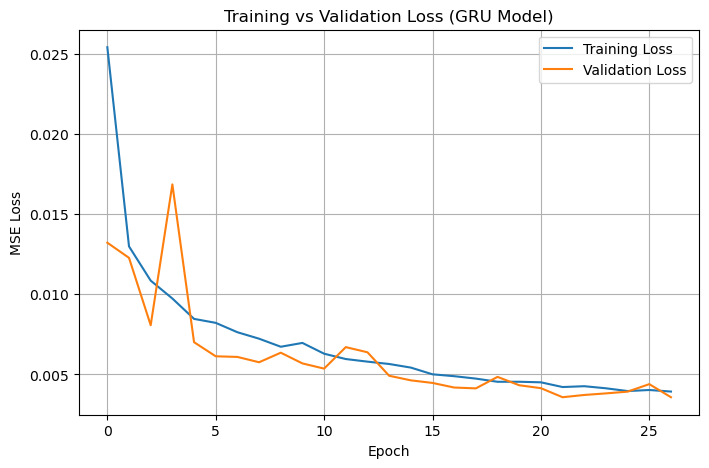

In [83]:
loss_key = 'loss'
val_loss_key = 'val_loss'

plt.figure(figsize=(8,5))
plt.plot(GRU_history.history[loss_key], label='Training Loss')
plt.plot(GRU_history.history[val_loss_key], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (GRU Model)")
plt.legend()
plt.grid(True)
plt.show()

### LSTM

In [30]:
# LSTM
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'
tf.config.experimental.enable_op_determinism()

# Create the model with encoder and decoder
LSTM_model = keras.Sequential([
    keras.Input(shape=(WINDOW_SIZE, NUM_FEATURES)),
    # Encoder
    layers.LSTM(units = 64,return_sequences = False),
    layers.RepeatVector(WINDOW_SIZE),

    #Decoder
    layers.LSTM(units = 64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(NUM_FEATURES, activation = 'linear'))
])

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
LSTM_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 93)        │         6,045 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,517 (310.61 KB)

 Trainable params: 79,517 (310.61 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
LSTM_history = LSTM_model.fit(
    train_ds,
    validation_data=(val_ds),
    epochs=30,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30


2026-01-13 20:28:17.745366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


   1191/Unknown 23s 16ms/step - loss: 0.0445 - mae: 0.1350

2026-01-13 20:28:37.654289: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/brandon/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1192/1192 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - loss: 0.0322 - mae: 0.1119 - val_loss: 0.0201 - val_mae: 0.0869
Epoch 2/30
   8/1192 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0226 - mae: 0.0851

2026-01-13 20:28:40.866304: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0184 - mae: 0.0783 - val_loss: 0.0138 - val_mae: 0.0687
Epoch 3/30
   7/1192 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0185 - mae: 0.0721

2026-01-13 20:29:03.136115: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0144 - mae: 0.0682 - val_loss: 0.0101 - val_mae: 0.0584
Epoch 4/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0124 - mae: 0.0622 - val_loss: 0.0087 - val_mae: 0.0555
Epoch 5/30
   8/1192 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0131 - mae: 0.0633

2026-01-13 20:29:47.840011: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0111 - mae: 0.0584 - val_loss: 0.0077 - val_mae: 0.0535
Epoch 6/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0099 - mae: 0.0551 - val_loss: 0.0076 - val_mae: 0.0511
Epoch 7/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089 - mae: 0.0526

KeyboardInterrupt: 